In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from vanilla.data import load_mnist
from vanilla.sgld import SGLD_sampler
from vanilla.nets.energy_function_anatomy_vanilla_cnn import Energy_function

CUDA = torch.cuda.is_available()
if CUDA:
    DEVICE = torch.device('cuda:0')
print('torch:', torch.__version__, 'CUDA:', CUDA)
## EBM hyper-parameters
sgld_noise_std = 7.5e-3
clipping_sgld = False
# LOAD_VERSION = 'ebm-lr=5.00E-05-data-std=7.50E-03-sgld-steps=4.00E+01-size=1.00E+00-std=5.00E-03-reg=1.00E-03-clip=False'
LOAD_VERSION = 'mnist-anatomy-vanilla-cnn'
print('Load trained energy function...')
ef = Energy_function()
if CUDA:
    ef.cuda().to(DEVICE)   
ef.load_state_dict(torch.load('../weights/ef-%s' % LOAD_VERSION))
for p in ef.parameters():
    p.requires_grad = False
print('Initialize SGLD sampler...')
sgld_sampler = SGLD_sampler(sgld_noise_std, clipping_sgld, CUDA, DEVICE)

torch: 1.3.0 CUDA: True
Load trained energy function...
Initialize SGLD sampler...


In [25]:
visual_sample_size = 100
pixels_size = 32
ebm_images = sgld_sampler.sgld_update(ef=ef, 
                                      batch_size=visual_sample_size, 
                                      pixels_size=pixels_size, 
                                      num_steps=100, 
                                      step_size=1,
                                      buffer_size=None,
                                      buffer_percent=None,
                                      persistent=False)
ebm_images = ebm_images.squeeze(0).cpu().view(visual_sample_size, pixels_size, pixels_size)
ebm_images = torch.clamp(ebm_images, min=-1, max=1) * 0.5 + 0.5

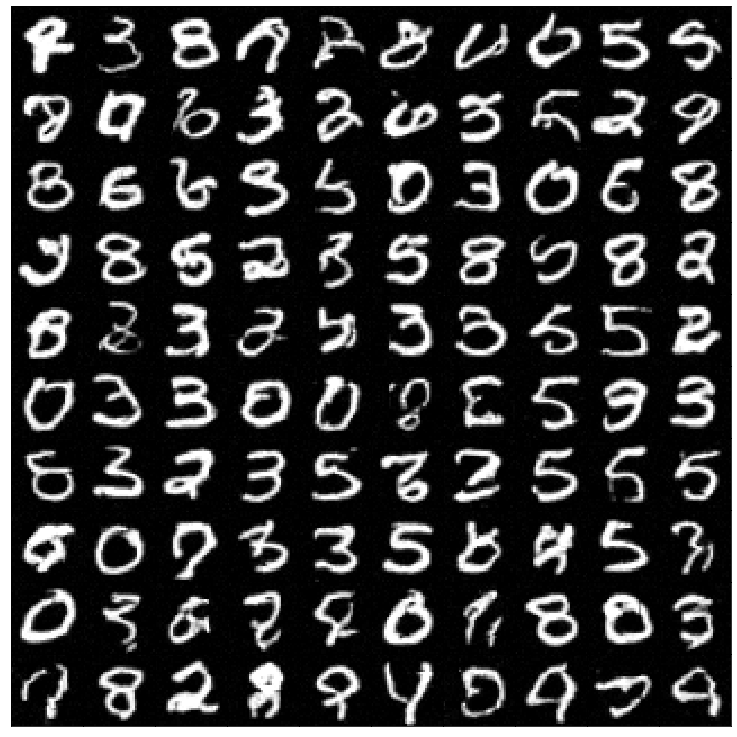

In [28]:
gs = gridspec.GridSpec(int(visual_sample_size/10), 10)
gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
fig = plt.figure(figsize=(10, 10*int(visual_sample_size/10)/ 10))
for i in range(visual_sample_size):
    ax = fig.add_subplot(gs[int(i/10), i%10])
    ax.imshow(ebm_images[i], cmap='gray', vmin=0, vmax=1.0)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('ebm_samples.png')